### Xử lí dữ liệu bộ dataset sau khi được làm sạch

    Import thư viện

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

    Đọc dữ liệu được làm sạch từ file clean_data.csv

In [3]:
data = pd.read_csv('./clean data/clean_data.csv')
data

,Date,Open,High,Low,Close,Volume
0,2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,2719900
1,2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,3346400
2,2017-06-07,1005.950012,1010.250000,1002.000000,1010.070007,2823000
3,2017-06-08,1012.059998,1013.609985,1006.109985,1010.270020,2767900
4,2017-06-09,1012.500000,1012.989990,927.000000,978.309998,7647700
...,...,...,...,...,...,...
1255,2022-05-27,2271.000000,2303.739990,2252.560059,2302.929932,4683000
1256,2022-05-31,2325.600098,2439.889893,2313.500000,2404.189941,7231700
1257,2022-06-01,2445.120117,2503.580078,2412.449951,2433.679932,6376400
1258,2022-06-02,2433.679932,2512.199951,2400.899902,2510.219971,5028000


    Tạo thêm các đặc trưng mới cho bộ dữ liệu

    'Have_Increase' - Giá trị tăng trưởng của cổ phiếu

+ Nếu giá mở cửa trừ giá đóng cửa < 0 -> giá trị sẽ bằng 0

+ Nếu giá mở cửa trừ giá đóng cửa > 0 -> giá trị sẽ bằng 1

In [4]:
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [0, 1]
data['Have_Increase'] = np.select(conditions, values, default = 1)
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase
0,2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,2719900,0
1,2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,3346400,1
2,2017-06-07,1005.950012,1010.250000,1002.000000,1010.070007,2823000,0
3,2017-06-08,1012.059998,1013.609985,1006.109985,1010.270020,2767900,1
4,2017-06-09,1012.500000,1012.989990,927.000000,978.309998,7647700,1


    'Target' - So sánh giá trị đóng phiên trước và phiên sau

+ Nếu giá trị đóng ngày sau > giá trị đóng ngày trước -> giá trị sẽ bằng 1

+ Nếu giá trị đóng ngày sau < giá tị đóng ngày trước -> giá trị sẽ bằng 0

In [5]:
newfeatures = pd.DataFrame()
newfeatures['Target'] = data.rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
newfeatures.head()

,Target
0,NaN
1,0.0
2,1.0
3,1.0
4,0.0


In [6]:
data = data.shift(1)
data['Target'] = newfeatures['Target']
data = data.iloc[1:]
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase,Target
1,2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,2719900.0,0.0,0.0
2,2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,3346400.0,1.0,1.0
3,2017-06-07,1005.950012,1010.250000,1002.000000,1010.070007,2823000.0,0.0,1.0
4,2017-06-08,1012.059998,1013.609985,1006.109985,1010.270020,2767900.0,1.0,0.0
5,2017-06-09,1012.500000,1012.989990,927.000000,978.309998,7647700.0,1.0,0.0


    Rolling means
- Đại lượng thể hiện tương quan giữa giá cổ phiếu hiện tại với giá cổ phiếu trung bình trong tuần, quý hoặc năm
- Nếu giá hiện tại cao hơn giá hàng năm thì nghĩa là cố phiếu đang có xu hướng tăng

    Sử dụng phương pháp rolling để tìm ra mean của cột Close với số ngày khác nhau (tuần, quý, năm)

In [7]:
weekly_mean = data.rolling(window=7).mean()['Close']
quarterly_mean = data.rolling(window=90).mean()['Close']
annual_mean = data.rolling(window=365).mean()['Close']

    Tỉ số giữa weekly_mean, quarterly_mean, annual_mean với cột Close

In [8]:
data['weekly_mean'] = weekly_mean / data['Close']
data['quarterly_mean'] = quarterly_mean / data['Close']
data['annual_mean'] = annual_mean / data['Close']

    Thêm tỉ số liên hệ giữa các rolling means với nhau

    Ví dụ : Nếu annual_mean >  weekly_mean -> cổ phiếu có xu hướng tăng

In [11]:
data['annual_weekly_mean'] = data['annual_mean'] / data['weekly_mean']
data['annual_quarterly_mean'] = data['annual_mean'] / data['quarterly_mean']

    Thêm tỉ số giữa giá mở cửa, giá cao, giá thấp và giá đóng cửa trong ngày. 
    
    Ví dụ : Nếu giá cao > giá đóng cửa -> cổ phiếu có xu hướng giảm vào cuối ngày.

In [14]:
data['open_close_ratio'] = data['Open'] / data['Close']
data['high_close_ratio'] = data['High'] / data['Close']
data['low_close_ratio'] = data['Low'] / data['Close']

    Dữ liệu sau khi được thêm mới

In [27]:
data.head(10)

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,2719900.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.995936,1.001849,0.992258
2,2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,3346400.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.008973,1.013460,0.998255
3,2017-06-07,1005.950012,1010.250000,1002.000000,1010.070007,2823000.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.995921,1.000178,0.992010
4,2017-06-08,1012.059998,1013.609985,1006.109985,1010.270020,2767900.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.001772,1.003306,0.995882
5,2017-06-09,1012.500000,1012.989990,927.000000,978.309998,7647700.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.034948,1.035449,0.947552
6,2017-06-12,967.000000,975.950012,945.000000,964.909973,9447200.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.002166,1.011442,0.979366
7,2017-06-13,977.989990,984.500000,966.099976,980.789978,4580000.0,0.0,0.0,1.013569,NaN,NaN,NaN,NaN,0.997145,1.003783,0.985022
8,2017-06-14,988.590027,990.340027,966.710022,976.469971,3974900.0,1.0,0.0,1.012952,NaN,NaN,NaN,NaN,1.012412,1.014204,0.990005
9,2017-06-15,958.700012,965.729980,950.859985,964.169983,5373900.0,0.0,1.0,1.020121,NaN,NaN,NaN,NaN,0.994327,1.001618,0.986195
10,2017-06-16,996.000000,999.750000,982.000000,987.710022,11472700.0,1.0,1.0,0.992574,NaN,NaN,NaN,NaN,1.008393,1.012190,0.994219


    Biểu diễn đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm')

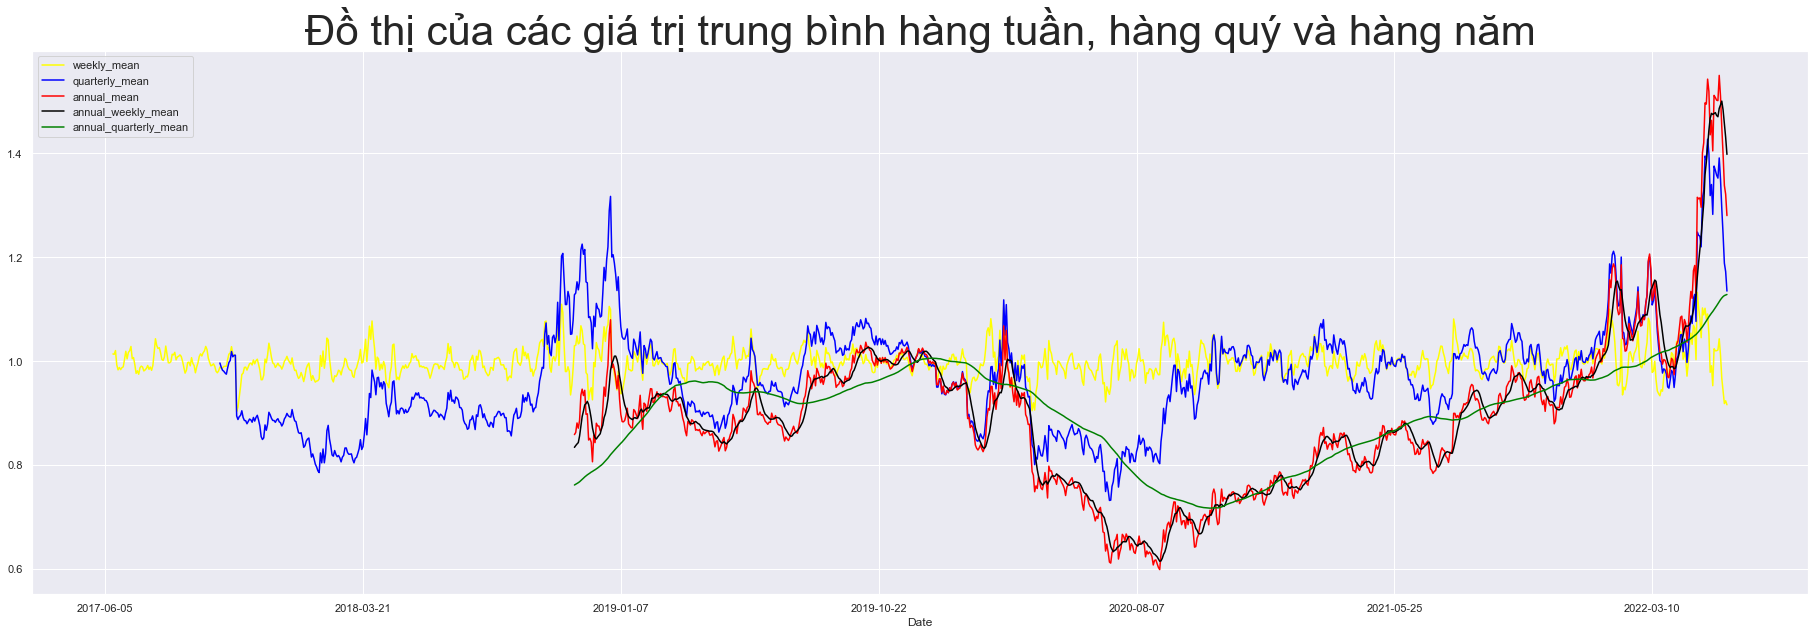

In [28]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='yellow', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
data.plot.line(x='Date', y='annual_weekly_mean',ax = ax1, color='black', label='annual_weekly_mean')
data.plot.line(x='Date', y='annual_quarterly_mean',ax = ax1, color='green', label='annual_quarterly_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm (2017-2022)", fontsize=42)

    Ta thấy dữ liệu trống nhiều. Việc tiếp theo ta cần phải xử lý dữ liệu trống
    
    Lựa chon random sample để có thể giữ được độ chính xác của dữ liệu mà tránh làm dữ liệu bị mất đi những đặc trưng 


    Tạo hàm Random Sample

In [29]:
def random_sample(columname):
    random_samples = data[columname].dropna().sample(n=data[columname].isnull().sum(),random_state=0)
    random_samples.index = data[data[columname].isnull()].index
    data[columname].update(random_samples) 

In [31]:
random_sample('weekly_mean')
random_sample('quarterly_mean')
random_sample('annual_mean')
random_sample('annual_weekly_mean')
random_sample('annual_quarterly_mean')

data.head(10)

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,2719900.0,0.0,0.0,0.987576,1.018824,0.779624,0.775397,0.769005,0.995936,1.001849,0.992258
2,2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,3346400.0,1.0,1.0,1.005859,1.026033,0.985359,0.971652,0.927710,1.008973,1.013460,0.998255
3,2017-06-07,1005.950012,1010.250000,1002.000000,1010.070007,2823000.0,0.0,1.0,1.011806,0.942515,0.703786,0.725950,0.861289,0.995921,1.000178,0.992010
4,2017-06-08,1012.059998,1013.609985,1006.109985,1010.270020,2767900.0,1.0,0.0,0.976128,0.976221,0.984081,1.009275,0.828111,1.001772,1.003306,0.995882
5,2017-06-09,1012.500000,1012.989990,927.000000,978.309998,7647700.0,1.0,0.0,0.970908,0.936657,1.133467,1.071862,0.991886,1.034948,1.035449,0.947552
6,2017-06-12,967.000000,975.950012,945.000000,964.909973,9447200.0,1.0,1.0,0.976212,1.039762,1.038612,1.016270,0.970435,1.002166,1.011442,0.979366
7,2017-06-13,977.989990,984.500000,966.099976,980.789978,4580000.0,0.0,0.0,1.013569,1.029882,1.067279,1.078291,0.994270,0.997145,1.003783,0.985022
8,2017-06-14,988.590027,990.340027,966.710022,976.469971,3974900.0,1.0,0.0,1.012952,0.949679,0.925874,0.954840,0.930235,1.012412,1.014204,0.990005
9,2017-06-15,958.700012,965.729980,950.859985,964.169983,5373900.0,0.0,1.0,1.020121,1.049353,0.726101,0.722779,0.717896,0.994327,1.001618,0.986195
10,2017-06-16,996.000000,999.750000,982.000000,987.710022,11472700.0,1.0,1.0,0.992574,0.971934,0.742456,0.757625,0.778347,1.008393,1.012190,0.994219


        Biểu diễn đồ thị

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm')

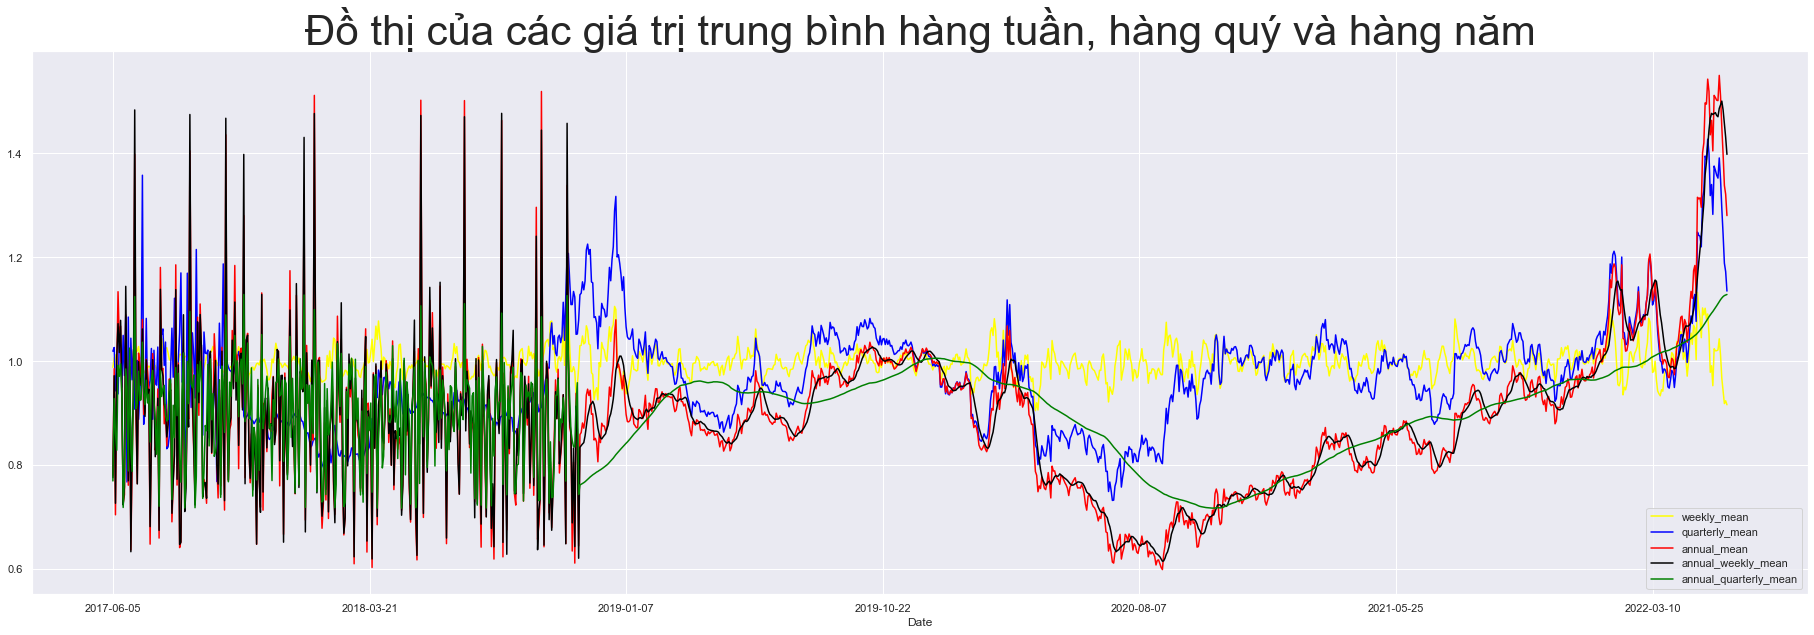

In [32]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='yellow', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
data.plot.line(x='Date', y='annual_weekly_mean',ax = ax1, color='black', label='annual_weekly_mean')
data.plot.line(x='Date', y='annual_quarterly_mean',ax = ax1, color='green', label='annual_quarterly_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm", fontsize=42)